In [78]:
import datetime as datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from prophet import Prophet
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

In [2]:
# Lendo dados da fonte externa para que todos consigam rodar o código no Colab sem ter que fazer upload do arquivo
# Mantendo Dataframe original para facilitar rodar as transformações multiplas vezes
df_raw = pd.read_csv(
    'https://raw.githubusercontent.com/agcorrea/fiap-techchallenge-grupo41/main/fase-2/dados/ibovespa_2003-01-01_2023-03-09.csv',
    parse_dates=['Data'], dayfirst=True,
    thousands='.', decimal=',')
df_raw.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,2023-03-09,105071,106540,106724,105053,"19,17M","-1,38%"
1,2023-03-08,106540,104228,106721,104228,"15,90M","2,22%"
2,2023-03-07,104228,104700,105179,103480,"12,58M","-0,45%"
3,2023-03-06,104700,103865,105171,103170,"14,28M","0,80%"
4,2023-03-03,103866,103326,104440,103323,"13,10M","0,52%"


In [3]:
# Explorando quais unidades estão presentes na coluna Vol.
df_raw['Vol.'].str.replace('\d', '', regex=True).unique()

array([',M', ',K', nan], dtype=object)

In [4]:
# Função para transformar a coluna `Vol.` de texto para números inteiros
def parse_vol(x):
  # Não faz nada caso não seja uma string
  if type(x) != str:
    return None

  # Multiplica por 1 milhão se possuí símbolo M ou por 1 mil se símbolo K
  multiplier = 1_000_000 if x.endswith('M') else 1_000

  # Remove o símbolo M ou K
  result = x[:-1]

  # Altera o separador para . ao invés de ,
  result = result.replace(',', '.')
  # Transforma a string em número
  result = float(result)

  # Multiplica o número pelo multiplicador e transforma em inteiro
  return int(result * multiplier)

In [5]:
# Função para transformar a coluna `Var%` de texto para número decimal
def parse_var(x):
  # Remove o símbolo de %
  result = x[:-1]

  # Altera o separador para . ao invés de ,
  result = result.replace(',', '.')

  # Transforma a string em número
  result = float(result)

  # Transforma em porcentagem
  return result / 100

In [6]:
# Cria um novo DataFrame a partir dos dados crus para aplicar as transformações
df = df_raw.copy()
df['Vol.'] = df['Vol.'].apply(parse_vol)
df['Var%'] = df['Var%'].apply(parse_var)
df = df.set_index('Data', drop=True)
df = df.sort_index()
df.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2003-01-02,11603,11291,11603,11291,195130000.0,0.0297
2003-01-03,11600,11632,11798,11600,197050000.0,-0.0002
2003-01-06,12020,11636,12032,11633,398400000.0,0.0362
2003-01-07,11876,12010,12018,11842,387980000.0,-0.0119
2003-01-08,11786,11875,11928,11757,217190000.0,-0.0076


In [7]:
# Quantidade de valores nulos por coluna
df.isnull().sum()

Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        1
Var%        0
dtype: int64

In [8]:
# Filtra dataframe procurando por valores nulos na coluna Vol.
df[df.isnull()['Vol.'] == True]

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2016-02-10,40377,40592,40592,39960,NaN,-0.0053


In [9]:
# Atualiza o valor nulo com o encontrado no Yahoo! Finance
df.loc['2016-02-10', 'Vol.'] = 3.7 * 1_000_000
df[df.index == '2016-02-10']

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2016-02-10,40377,40592,40592,39960,3700000.0,-0.0053


In [10]:
print('Teste de sanidade, nenhum valor deve ser nulo:')

# Quantidade de valores nulos por coluna
df.isnull().sum()

Teste de sanidade, nenhum valor deve ser nulo:


Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        0
Var%        0
dtype: int64

In [11]:
df.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2003-01-02,11603,11291,11603,11291,195130000.0,0.0297
2003-01-03,11600,11632,11798,11600,197050000.0,-0.0002
2003-01-06,12020,11636,12032,11633,398400000.0,0.0362
2003-01-07,11876,12010,12018,11842,387980000.0,-0.0119
2003-01-08,11786,11875,11928,11757,217190000.0,-0.0076


In [12]:
#  Criação de um  data frame padrão
df_prophet = df.copy()
df_prophet= df_prophet.drop(columns=["Abertura","Máxima", "Vol.", "Var%", "Mínima"])

# verificando as primeiras 5 linhas
df_prophet.head()


,Último
Data,
2003-01-02,11603
2003-01-03,11600
2003-01-06,12020
2003-01-07,11876
2003-01-08,11786


In [13]:
# renomeando as colunas
df_prophet.index.rename('ds', inplace=True)
df_prophet = df_prophet.rename(columns={'Último': 'y'})
df_prophet['ds'] = df.index
df_prophet.head()

,y,ds
ds,,
2003-01-02,11603,2003-01-02
2003-01-03,11600,2003-01-03
2003-01-06,12020,2003-01-06
2003-01-07,11876,2003-01-07
2003-01-08,11786,2003-01-08


In [14]:
df_train = df_prophet.loc[(df_prophet.index >= '2016-01-02') & (df_prophet.index < '2020-01-01')]
df_train

,y,ds
ds,,
2016-01-04,42141,2016-01-04
2016-01-05,42419,2016-01-05
2016-01-06,41773,2016-01-06
2016-01-07,40695,2016-01-07
2016-01-08,40612,2016-01-08
...,...,...
2019-12-20,115121,2019-12-20
2019-12-23,115863,2019-12-23
2019-12-26,117203,2019-12-26


In [69]:
df_test = df_prophet.loc[(df_prophet.index >= '2020-01-01') & (df_prophet.index < '2020-01-30')]

In [16]:
prophet_model = Prophet()
prophet_model.fit(df_train)

21:04:45 - cmdstanpy - INFO - Chain [1] start processing
21:04:46 - cmdstanpy - INFO - Chain [1] done processing


In [17]:
future = prophet_model.make_future_dataframe(periods=30)
future

,ds
0,2016-01-04
1,2016-01-05
2,2016-01-06
3,2016-01-07
4,2016-01-08
...,...
1013,2020-01-25
1014,2020-01-26
1015,2020-01-27
1016,2020-01-28


In [18]:
y_pred = prophet_model.predict(future)
y_pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-01-04,36040.625718,32932.435865,38757.951715,36040.625718,36040.625718,-208.091187,-208.091187,-208.091187,-1182.969729,-1182.969729,-1182.969729,974.878542,974.878542,974.878542,0.0,0.0,0.0,35832.534531
1,2016-01-05,36173.999673,33233.603254,38881.026487,36173.999673,36173.999673,-2.859932,-2.859932,-2.859932,-1230.051281,-1230.051281,-1230.051281,1227.191349,1227.191349,1227.191349,0.0,0.0,0.0,36171.139741
2,2016-01-06,36307.373628,33615.335826,39516.298193,36307.373628,36307.373628,303.443528,303.443528,303.443528,-1167.942487,-1167.942487,-1167.942487,1471.386015,1471.386015,1471.386015,0.0,0.0,0.0,36610.817156
3,2016-01-07,36440.747583,34069.014111,39850.162468,36440.747583,36440.747583,439.349314,439.349314,439.349314,-1265.546274,-1265.546274,-1265.546274,1704.895587,1704.895587,1704.895587,0.0,0.0,0.0,36880.096897
4,2016-01-08,36574.121539,34583.318821,40305.370131,36574.121539,36574.121539,789.029744,789.029744,789.029744,-1136.395710,-1136.395710,-1136.395710,1925.425454,1925.425454,1925.425454,0.0,0.0,0.0,37363.151283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1013,2020-01-25,115116.590601,118496.824441,124333.581460,114972.721048,115251.367467,6155.212287,6155.212287,6155.212287,2991.450234,2991.450234,2991.450234,3163.762053,3163.762053,3163.762053,0.0,0.0,0.0,121271.802888
1014,2020-01-26,115180.641135,118545.458085,124018.004426,115018.429090,115334.013564,6134.668779,6134.668779,6134.668779,2991.455246,2991.455246,2991.455246,3143.213532,3143.213532,3143.213532,0.0,0.0,0.0,121315.309914
1015,2020-01-27,115244.691670,114224.897365,119910.465780,115059.874743,115411.779565,1940.136894,1940.136894,1940.136894,-1182.969729,-1182.969729,-1182.969729,3123.106623,3123.106623,3123.106623,0.0,0.0,0.0,117184.828564
1016,2020-01-28,115308.742204,114233.507449,120121.527315,115111.684899,115486.514590,1874.913961,1874.913961,1874.913961,-1230.051281,-1230.051281,-1230.051281,3104.965242,3104.965242,3104.965242,0.0,0.0,0.0,117183.656165


In [71]:
y_pred_validation = y_pred[y_pred['ds'] > '2020']

In [74]:
df_test_validation = df_test.drop(columns={'ds'}).reset_index()
df_test_validation = df_test_validation.merge(y_pred_validation, on='ds', how='left')

In [79]:
np.mean(np.abs((df_test_validation.y.values - df_test_validation.yhat.values) / df_test_validation.y.values))

0.015261115188965103

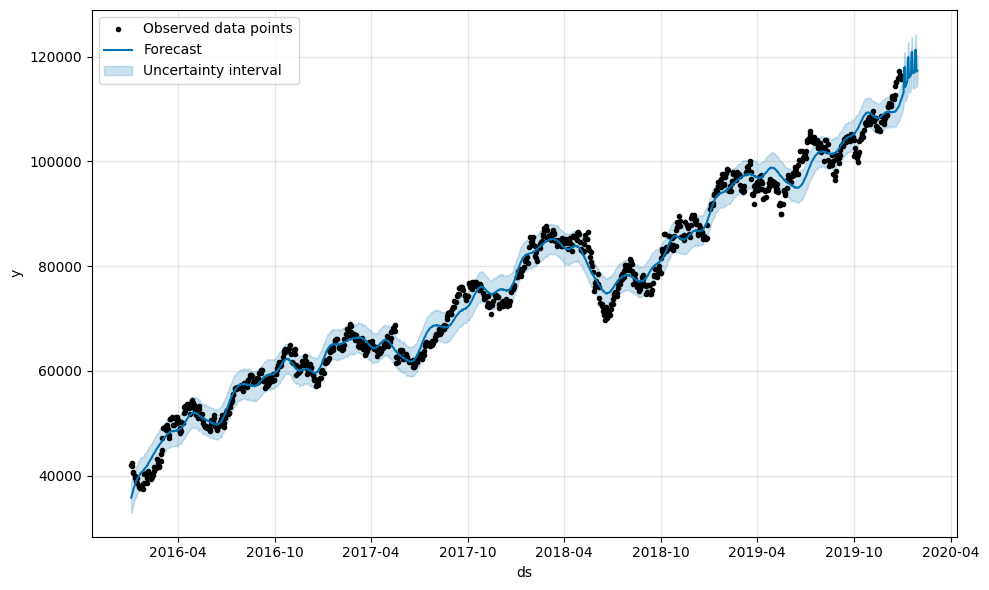

In [19]:
fig = prophet_model.plot(y_pred)
plt.legend()

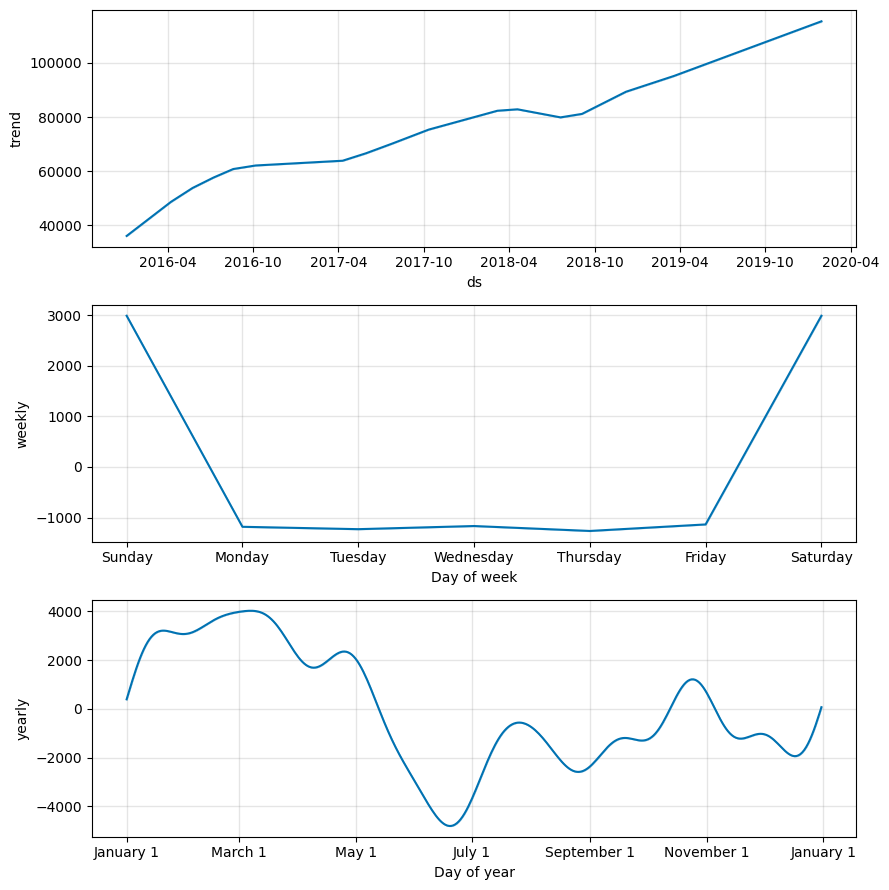

In [21]:
prophet_model.plot_components(y_pred);

In [23]:
df_cross_validation = cross_validation(prophet_model, horizon='30 days')

  0%|          | 0/71 [00:00<?, ?it/s]

21:08:49 - cmdstanpy - INFO - Chain [1] start processing
21:08:49 - cmdstanpy - INFO - Chain [1] done processing
21:08:50 - cmdstanpy - INFO - Chain [1] start processing
21:08:50 - cmdstanpy - INFO - Chain [1] done processing
21:08:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:08:50 - cmdstanpy - INFO - Chain [1] start processing
21:08:53 - cmdstanpy - INFO - Chain [1] done processing
21:08:53 - cmdstanpy - INFO - Chain [1] start processing
21:08:54 - cmdstanpy - INFO - Chain [1] done processing
21:08:54 - cmdstanpy - INFO - Chain [1] start processing
21:08:54 - cmdstanpy - INFO - Chain [1] done processing
21:08:55 - cmdstanpy - INFO - Chain [1] start processing
21:08:55 - cmdstanpy - INFO - Chain [1] done processing
21:08:55 - cmdstanpy - INFO - Chain [1] start processing
21:08:55 - cmdstanpy - INFO - Chain [1] done processing
21:08:56 - cmdstanpy - INFO - Chain [1] start process

In [31]:
df_cross_validation

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-01-16,61401.379872,60092.630516,62718.200625,63831,2017-01-14
1,2017-01-17,61263.347623,59964.047673,62616.002888,64354,2017-01-14
2,2017-01-18,61183.451344,60007.718532,62476.159324,64150,2017-01-14
3,2017-01-19,61099.368754,59916.709243,62347.756239,63951,2017-01-14
4,2017-01-20,60957.674204,59674.508650,62170.857852,64521,2017-01-14
...,...,...,...,...,...,...
1435,2019-12-20,104985.566072,102211.986291,107618.582833,115121,2019-11-30
1436,2019-12-23,105311.522856,102774.786900,107887.298234,115863,2019-11-30
1437,2019-12-26,105917.065244,103095.105804,108625.338539,117203,2019-11-30
1438,2019-12-27,106323.023393,103834.370668,109037.619062,116534,2019-11-30


***

In [34]:
regression_report = performance_metrics(df_cross_validation)
regression_report

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,1.007247e+07,3173.715355,2506.176943,0.030095,0.025421,0.030237,0.469052
1,4 days,9.427569e+06,3070.434603,2422.794746,0.029332,0.024397,0.029435,0.504774
2,5 days,8.610210e+06,2934.315931,2347.914569,0.028592,0.023342,0.028619,0.510349
3,6 days,9.124639e+06,3020.701797,2393.393141,0.029403,0.020944,0.029262,0.534858
4,7 days,1.110125e+07,3331.854289,2602.164612,0.031642,0.020944,0.031414,0.519531
5,8 days,1.332596e+07,3650.474169,2821.228122,0.034295,0.024686,0.034046,0.482337
6,9 days,1.567878e+07,3959.644243,3126.050295,0.037957,0.028173,0.037841,0.409568
7,10 days,1.747292e+07,4180.062037,3342.961448,0.040870,0.033270,0.040880,0.360000
8,11 days,1.799072e+07,4241.546689,3390.215466,0.041259,0.034229,0.041472,0.364651
9,12 days,1.692456e+07,4113.947348,3298.609481,0.040381,0.033402,0.040632,0.379535


In [56]:
regression_report.mape.mean()

0.045083396937650747

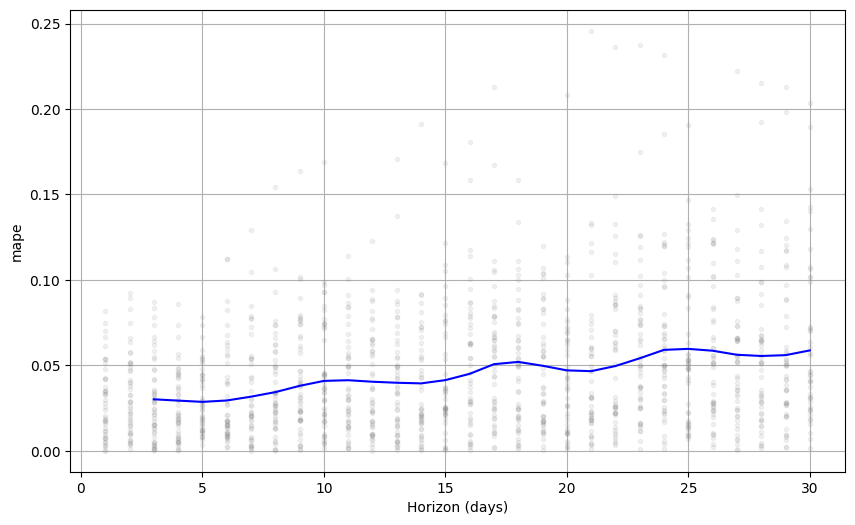

In [41]:
plot_cross_validation_metric(df_cross_validation, metric='mape');